<img src="https://github.com/Multiomics-Analytics-Group/course_protein_language_modeling/blob/main/img/nb_logo.png?raw=1" width="600">

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Multiomics-Analytics-Group/course_protein_language_modeling/blob/main/notebooks/prediction.ipynb)


This is a version of the notebook from [Meta Research](https://research.facebook.com/) --- [here](https://github.com/facebookresearch/esm/blob/main/examples/sup_variant_prediction.ipynb) using the output from the [Embeddings notebook](https://colab.research.google.com/github/Multiomics-Analytics-Group/course_protein_language_modeling/blob/main/notebooks/embeddings.ipynb)

In [1]:
# Install requirements
#!pip install h5py > /dev/null
!wget https://github.com/Multiomics-Analytics-Group/course_protein_language_modeling/raw/main/data/per_protein_embeddings.h5.zip -O per_protein_embeddings.h5.zip

--2025-01-08 01:32:18--  https://github.com/Multiomics-Analytics-Group/course_protein_language_modeling/raw/main/data/per_protein_embeddings.h5.zip
Resolving github.com (github.com)... 140.82.121.4
connected. to github.com (github.com)|140.82.121.4|:443... 
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Multiomics-Analytics-Group/course_protein_language_modeling/main/data/per_protein_embeddings.h5.zip [following]
--2025-01-08 01:32:18--  https://raw.githubusercontent.com/Multiomics-Analytics-Group/course_protein_language_modeling/main/data/per_protein_embeddings.h5.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
connected. to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... 
200 OKequest sent, awaiting response... 
Length: 20295801 (19M) [application/zip]
Saving to: ‘per_protein_embeddings.h5.zip’

per_protein_embeddi 100%[===========

# Predicting Varient Effect from Sequence Embeddings

In this notebook we will use the embeddings we generated in embeddings.ipynb to train and optimize various machine learning models in sklearn.

Each observation in our dataset $--$ which we created in embeddings.ipynb (or can be found in the git repo at _data/per_protein_embeddings.h5.zip_)$--$contains: 
- value: an embedded representation of the mutated ß-lactamase sequence
- key: `{index}|beta-lactamase_{mutation}|{scaled_varient_effect}` where the target value is the scaled_varient_effect, which describes the scaled effect of the mutation

**Goal:**
Train a regression model in to predict the "effect" score of a $\beta$-$lactamase$ variant given the embedding.

In [2]:
# imports
import h5py
import zipfile
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy

# for fine-tuning
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline

# dimensionality reduction
from sklearn.decomposition import PCA

# models
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

# path to files
zip_path = 'per_protein_embeddings.h5.zip'
filename = 'per_protein_embeddings.h5'

In [3]:
# unzips the file and puts it in the current working directory
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    # extract the filename of interest
    zip_ref.extract(filename)

In [4]:
# functions to help us with reading in our dataset

def read_hdf5(path:str) -> dict:
    '''
    read in the h5 file to a dictionary
    '''
    # empty dict and list
    weights = {}
    
    # open file
    with h5py.File(path, 'r') as f:
        # append to dict
        for key in f.keys():
            weights[key] = list(f[key])
            
    return weights

def emb_to_df(emb:dict) -> pd.DataFrame:
    '''
    Takes the dictionary from read_hdf5() to create a dataframe. 
    This function is super specific to per_protein_embeddings.h5
    '''
    # to dataframe
    df_seq = pd.DataFrame.from_dict(emb, orient='index').reset_index()
    
    # additional formatting for our purposes
    # making each part of key its own column
    header = df_seq['index'].str.split('|', expand=True).rename(
        columns={
            0:'index_value',
            1:'mutation',
            2:'scaled_varient_effect'
        }
    )
    
    # combining with sequence embeddings
    df = pd.concat([header, df_seq.drop('index', axis=1)], axis=1)

    # target column to float dtype
    df['scaled_varient_effect'] = df['scaled_varient_effect'].astype(float)
            
    return df

### The Dataset

Here, we read in the embeddings as a dataframe and take a look. 

In [5]:
# load in embeddings
embeddings = read_hdf5(filename)

# to dataframe
df = emb_to_df(embeddings)

In [6]:
# What does our data look like? 
print(df.shape)
print(f'Missing data? {df.isna().any().any()}')
display(df.head())

(5397, 1027)
Missing data? False


,index_value,mutation,scaled_varient_effect,0,1,2,3,4,5,6,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,0,beta-lactamase_P20P,1.581033,0.052989,0.103709,0.027287,0.048142,-0.041467,0.052440,-0.070206,...,-0.056122,0.009586,0.016208,-0.008718,0.050708,-0.032934,-0.010124,0.002992,-0.028268,0.004362
1,1000,beta-lactamase_S221R,0.998278,0.053008,0.104242,0.026439,0.048443,-0.043144,0.052731,-0.069874,...,-0.056800,0.009443,0.017835,-0.008153,0.049308,-0.032000,-0.010796,0.002908,-0.027387,0.003949
2,1001,beta-lactamase_Q37H,0.998254,0.050949,0.104730,0.025892,0.047978,-0.042739,0.052258,-0.070305,...,-0.055720,0.009551,0.016762,-0.007657,0.051110,-0.031725,-0.010204,0.003038,-0.027681,0.005302
3,1002,beta-lactamase_F13L,0.998188,0.053440,0.103653,0.028830,0.047122,-0.040457,0.051033,-0.068828,...,-0.056381,0.010812,0.015836,-0.008844,0.049810,-0.034179,-0.010281,0.002779,-0.029671,0.004741
4,1003,beta-lactamase_A182C,0.998172,0.052086,0.103112,0.023130,0.051180,-0.045987,0.054601,-0.072348,...,-0.052960,0.007204,0.014539,-0.010705,0.050847,-0.030501,-0.010859,0.000829,-0.023961,0.002978


Further getting the dataset ready by separating the features (embedding only) and target (scaled_varient_effect). 

In [7]:
# target
y = df['scaled_varient_effect']

# isolating features
X = df.drop(['index_value', 'mutation', 'scaled_varient_effect'], axis=1)

# check
print(X.shape, y.shape)

(5397, 1024) (5397,)


### Train / Test Split

Here we choose to follow the Envision paper, using 80% of the data for training, but we actually found that pre-trained ESM embeddings require fewer downstream training examples to reach the same level of performance.

The test set will be used at the end of our notebook to assess how the model performs on never before seen data. 

The training set will be used to train and fine tune hyperparameters via a validation set (i.e., an intermediary 'test' set), which we will incorporate later in the notebook via cross-validation.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42)

### PCA

Principal Component Analysis (PCA) is a popular technique for dimensionality reduction. Given `n_features` (1024 in our case), PCA computes a new set of `components` that "best explain the data" by capturing the variance in the data. 


Using a subset of `components` reduces the number of dimensons (e.g., columns), which enables downstream models to be trained faster with minimal loss in performance.  

For the below example, we arbitrarily set `components` to 50, but feel free to change it!

In [9]:
num_pca_components = 50

# instantiate
pca = PCA(num_pca_components)

# fit to the data and keep only num_pca_componenrs
Xs_train_pca = pca.fit_transform(X_train)

In [10]:
# how much variance in the data is captured in the selected components?

# calculating variance captured
exp_var = sum(pca.explained_variance_ratio_)

print(f'{exp_var} of variance is captured in {num_pca_components} PCs.')

0.9216000437736511 of variance is captured in 50 PCs.


## Visualize Embeddings

Here, we plot the first two principal components on the x- and y- axes. Each point is then colored by its scaled effect (what we want to predict).

Visually, we can see a separation based on color/effect, suggesting that our representations are useful for this task, without any task-specific training!

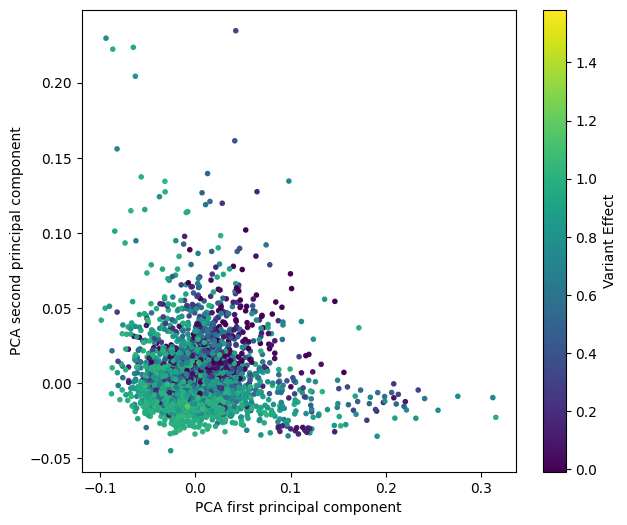

In [11]:
fig_dims = (7, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sc = ax.scatter(Xs_train_pca[:,0], Xs_train_pca[:,1], c=y_train, marker='.')
ax.set_xlabel('PCA first principal component')
ax.set_ylabel('PCA second principal component')
plt.colorbar(sc, label='Variant Effect')
plt.show()

### Setting up our pipeline process

Sklearn has a [`Pipeline` class](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) that allows us to chain together pre-processing and model training steps. The purpose of the pipeline is to assemble several steps that can be cross-validated together while setting different parameters. We will later create a list of `params` consisting of the different hyperparameters we wish to fine-tune using cross-validation.

The sequence in the `Pipeline()` will be:

- A Dimensionality Reduction technique to reduce the number of dimensions ( `PCA()` ), and
- Training a regressor model on the training dataset

where the data will be passed from one transformer to the next in that order. 

In [12]:
pipe = Pipeline(
    [
        ('reduce_dim', PCA(n_components=50)),
        ('model', KNeighborsRegressor()) 
    ]
)

With no additional fine-tuning of the we can see how the model performs by fitting our pipeline to the train and test data. Here, a [score](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor.score) closer to 1.0 is better. 

In [13]:
pipe.fit(X_train, y_train)
print(pipe.score(X_train, y_train))
print(pipe.score(X_test, y_test))

0.7750546372422542
0.6229243219551783


This is an okay score and all.. but can we train a model to achieve a better score? Specifically:
- Did we include a good amount of components in our data?
- What about the KNeighborsRegressor() hyperparameters of n_neighbors, leaf_size, etc.? Can these be fine-tuned to get a model that has a better score on the test set?
- And, is KNighborsRegressor() the best fit? What about another algorithm like a support vector regression (SVR) and its parameters?

### Initialize parameter-grid for fine-tuning

We will let [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) investigate which algorithm and algorithm-specific hyperparameters result in the best model (i.e., highest score) by completing a cross-validated grid-search over a parameter grid we provide.

We will need to provide the options for `GridSearchCV` to explore. When selecting the optimal set of parameters to include we should consider the algorithm, our problem and what we know about the data. 

From [the documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) we know that GridSearchCV() expects the `param_grid` to be a list of dictionaries of lists. 

In [14]:
# creating a dictionary for each model 

kn_grid = {
    'model': [KNeighborsRegressor()],
    'model__n_neighbors': [5, 10],
    'model__weights': ['uniform', 'distance'],
    'model__leaf_size' : [15, 30],
    'model__p' : [1, 2],
    'reduce_dim__n_components': [50, 100]
}

svr_grid = {
    'model': [SVR(gamma='scale', degree=3)],
    'model__C': [0.01, 0.1, 1.0, 10.0],
    'model__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'reduce_dim__n_components': [50, 100]
}

# putting in a list
params = [kn_grid, svr_grid]

### Run Grid Search

(This will take a few minutes on a single core)


In [15]:
# instantiating the grid search
best_model = GridSearchCV(
    estimator=pipe, 
    param_grid=params, 
    scoring='r2',
    cv=5, # 5 folds (validation)
    verbose=3,
    n_jobs=-1 #if wanting verbosity during run than n_jobs must be 1 (default)
)

In [16]:
# running
best_model.fit(X_train, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('reduce_dim', PCA(n_components=50)),
                                       ('model', KNeighborsRegressor())]),
             n_jobs=-1,
             param_grid=[{'model': [KNeighborsRegressor()],
                          'model__leaf_size': [15, 30],
                          'model__n_neighbors': [5, 10], 'model__p': [1, 2],
                          'model__weights': ['uniform', 'distance'],
                          'reduce_dim__n_components': [50, 100]},
                         {'model': [SVR()], 'model__C': [0.01, 0.1, 1.0, 10.0],
                          'model__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                          'reduce_dim__n_components': [50, 100]}],
             scoring='r2', verbose=3)

So what was the best model and hyperparameters as determined by the grid search?

In [17]:
# look at parameters
best_model.best_estimator_.get_params()

{'memory': None,
 'steps': [('reduce_dim', PCA(n_components=100)), ('model', SVR())],
 'transform_input': None,
 'verbose': False,
 'reduce_dim': PCA(n_components=100),
 'model': SVR(),
 'reduce_dim__copy': True,
 'reduce_dim__iterated_power': 'auto',
 'reduce_dim__n_components': 100,
 'reduce_dim__n_oversamples': 10,
 'reduce_dim__power_iteration_normalizer': 'auto',
 'reduce_dim__random_state': None,
 'reduce_dim__svd_solver': 'auto',
 'reduce_dim__tol': 0.0,
 'reduce_dim__whiten': False,
 'model__C': 1.0,
 'model__cache_size': 200,
 'model__coef0': 0.0,
 'model__degree': 3,
 'model__epsilon': 0.1,
 'model__gamma': 'scale',
 'model__kernel': 'rbf',
 'model__max_iter': -1,
 'model__shrinking': True,
 'model__tol': 0.001,
 'model__verbose': False}

SVR with a rbf kernel and a $C$ value of 1.0 trained on a dataset of 100 principal components (that's only 10% of the number of features we started with!) was selected as the best estimator. 

Using the GridSearchCV `.predict()` method will [call predict on the best found parameters.](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV.predict)

Let's take a look at how the model scores on the train and (most importantly) the test set, sequences it has never seen before.  

In [18]:
print(f'training set score {best_model.score(X_train, y_train)}')
print(f'test set score {best_model.score(X_test, y_test)}')

training set score 0.8599278656815466
test set score 0.7446584954007347


In [19]:
preds = best_model.predict(X_test)
print(f'{scipy.stats.spearmanr(y_test, preds)}')

SignificanceResult(statistic=np.float64(0.8137023020079442), pvalue=np.float64(3.046295551504271e-256))


We achieved a spearman rho of 0.815 on the test set!

In conclusion, our downstream model was able to use fixed pre-trained ESM embedding representations and obtain a decent result.